In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import utilAnalysis as utilA
import constants as const
import matplotlib.pyplot as plt

2024-02-08 00:42:45.466885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [3]:
root = r"..."
model = const.VARIANTS
dataset = dict(zip(const.DS_LABEL, const.DS_NAME))
dataset_alias = list(dataset.keys())

In [4]:
def walk_dict(d,depth=0):
    for k,v in sorted(d.items(),key=lambda x: x[0]):
        space = "  "*depth
        if isinstance(v, dict):
            print(f"{space}{k}")
            walk_dict(v,depth+1)
        else:
            print(f"{space}{k} {v}")
            # print ("  ")*depth + "%s %s" % (k, v) 

In [5]:
load_data = {}
for m in model:
    item = {}
    for d_a in dataset_alias:
        _ = {}
        _['name'] = dataset[d_a]
        _['true'] = os.path.join(root, m, _['name'], 'fold0', 'true_Y.npy')
        _['pred'] = os.path.join(root, m, _['name'], 'fold0', 'pred_Y.npy')
        _['logits'] = os.path.join(root, m, _['name'], 'fold0', 'logits.npy')
        _['feats'] = os.path.join(root, m, _['name'], 'fold0', 'feats.npy')
        item[d_a] = _
    load_data[m] = item

walk_dict(load_data, depth=0)

base
  source
    feats /Volumes/HK_WD2TB/UZH_MP/base/_base/fold0/feats.npy
    logits /Volumes/HK_WD2TB/UZH_MP/base/_base/fold0/logits.npy
    name _base
    pred /Volumes/HK_WD2TB/UZH_MP/base/_base/fold0/pred_Y.npy
    true /Volumes/HK_WD2TB/UZH_MP/base/_base/fold0/true_Y.npy
  source+unknown
    feats /Volumes/HK_WD2TB/UZH_MP/base/_base_unkn/fold0/feats.npy
    logits /Volumes/HK_WD2TB/UZH_MP/base/_base_unkn/fold0/logits.npy
    name _base_unkn
    pred /Volumes/HK_WD2TB/UZH_MP/base/_base_unkn/fold0/pred_Y.npy
    true /Volumes/HK_WD2TB/UZH_MP/base/_base_unkn/fold0/true_Y.npy
  target-1.1
    feats /Volumes/HK_WD2TB/UZH_MP/base/adl/fold0/feats.npy
    logits /Volumes/HK_WD2TB/UZH_MP/base/adl/fold0/logits.npy
    name adl
    pred /Volumes/HK_WD2TB/UZH_MP/base/adl/fold0/pred_Y.npy
    true /Volumes/HK_WD2TB/UZH_MP/base/adl/fold0/true_Y.npy
  target-1.2
    feats /Volumes/HK_WD2TB/UZH_MP/base/forthtrace/fold0/feats.npy
    logits /Volumes/HK_WD2TB/UZH_MP/base/forthtrace/fold0/logits.n

In [6]:
def source_load(model:str, unknown=True, feats_out=False):

    if unknown:
        s_true = np.load(load_data[model]['source+unknown']['true'])
        s_pred = np.load(load_data[model]['source+unknown']['pred'])
        s_logits = np.load(load_data[model]['source+unknown']['logits'])
        if feats_out:
            s_feats = np.load(load_data[model]['source+unknown']['feats'])
        else:
            s_feats = None
    else:
        s_true = np.load(load_data[model]['source']['true'])
        s_pred = np.load(load_data[model]['source']['pred'])
        s_logits = np.load(load_data[model]['source']['logits'])
        if feats_out:
            s_feats = np.load(load_data[model]['source']['feats'])
        else:
            s_feats = None

    return s_true, s_pred, s_logits, s_feats

In [7]:
def target_load(model:str, feats_out=False):
    t_true = None
    t_pred = None
    t_logits = None
    t_feats = None

    for idx, k in enumerate(load_data[model].keys()):

        if k not in ['source', 'source+unknown']:
            true = np.load(load_data[model][k]['true'])
            pred = np.load(load_data[model][k]['pred'])
            logits = np.load(load_data[model][k]['logits'])
            if feats_out:
                feats = np.load(load_data[model][k]['feats'])
            else:
                feats = None

            if not isinstance(t_true, np.ndarray):
                t_true = true
                t_pred = pred
                t_logits = logits
                if feats_out:
                    t_feats = feats
                continue

            t_true = np.append(t_true, true, axis=0)
            t_pred = np.append(t_pred, pred, axis=0)
            t_logits = np.append(t_logits, logits, axis=0)
            if feats_out:
                t_feats = np.append(t_feats, feats, axis=0)

    return t_true, t_pred, t_logits, t_feats

In [8]:
s_true, _, _, _ = source_load('base')
t_true, _, _, _ = target_load('base')

In [9]:
np.unique(s_true, return_counts=True)

(array(['bicycling', 'mixed', 'sit-stand', 'sleep', 'unknown', 'vehicle',
        'walking'], dtype='<U9'),
 array([ 2163, 34859, 65086, 68449, 15625, 15336, 14863]))

In [10]:
np.unique(t_true, return_counts=True)

(array(['bicycling', 'mixed', 'sit-stand', 'sleep', 'unknown', 'walking'],
       dtype='<U9'),
 array([   598,   2549,   9649, 370611,   1663,  10422]))

# Open-set. balanced OSCR

['base', 'var-C', 'var-CU']
base:
CCRofFPR@0.1 = 0.0003			Accuracy = 0.6638
THRofFPR@0.1 = 1.0000
var-C:
CCRofFPR@0.1 = 0.2971			Accuracy = 0.6506
THRofFPR@0.1 = 0.9455
var-CU:
CCRofFPR@0.1 = 0.5106			Accuracy = 0.6396
THRofFPR@0.1 = 0.6422


Text(0.5, 0, 'FPR')

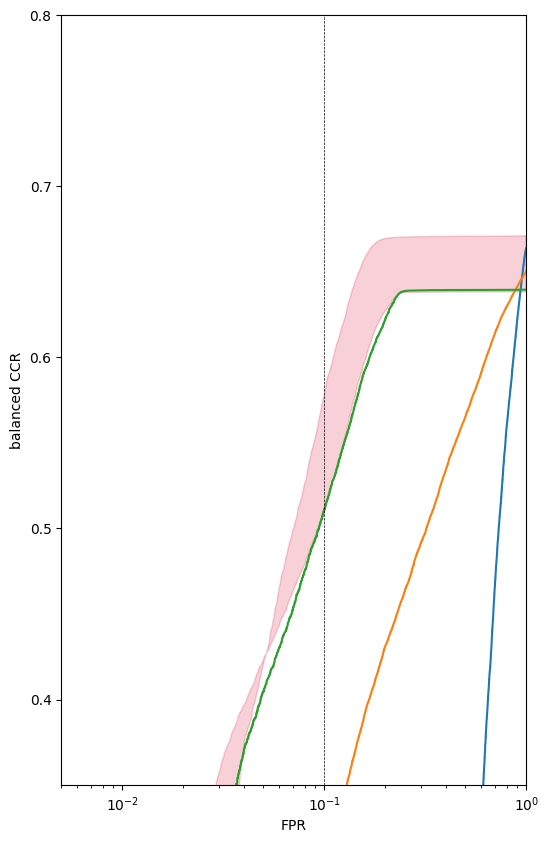

In [136]:
models = const.VARIANTS.copy()
# models.remove('base')
# models.remove('var-C')
models.remove('var-U')
# models.remove('var-CU')
models.remove('var-CUA-s')
models.remove('var-CUA-r')
models.remove('var-CUA-a')
models.remove('var-CUA-sr')
models.remove('var-CUA-sa')
models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

plt.figure(figsize=(6,10))
for m in models:
    CCR = np.load(f'./_inference/oscr_result/gpu/{m}_CCR.npy')
    FPR = np.load(f'./_inference/oscr_result/gpu/{m}_FPR.npy')
    Threshold = np.load(f'./_inference/oscr_result/gpu/{m}_Threshold.npy')
    ccr_at_fpr = utilA.find_ccr_at_fpr(FPR,CCR,0.1)
    thr_at_fpr = utilA.find_thr_at_fpr(FPR,Threshold,0.1)
    print(f"{m}:")
    print(f"CCRofFPR@0.1 = {ccr_at_fpr:.4f}\t\t\tAccuracy = {CCR[0]:.4f}")
    print(f"THRofFPR@0.1 = {thr_at_fpr:.4f}")
    plt.plot(FPR, CCR, label=m, color=const.VARIANTS_COLOR[m])

s_fpr_fill, s_ccr1_fill, s_ccr2_fill = utilA.cua_oscr_range('var-CUA-s', 'var-CUA-a')
plt.fill_between(s_fpr_fill, s_ccr1_fill, s_ccr2_fill, interpolate=True, color='crimson', alpha=0.2)

plt.axvline(0.1, color='black', ls='--', lw=.5)
plt.xscale('log')
plt.xlim(0.005, 1)
plt.ylim(0.35, 0.8)
plt.ylabel("balanced CCR")
plt.xlabel("FPR")
# plt.legend()

['var-CUA-s', 'var-CUA-r', 'var-CUA-a', 'var-CUA-sr', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']
var-CUA-s:
CCRofFPR@0.1 = 0.5777			Accuracy = 0.6710
THRofFPR@0.1 = 0.5433
var-CUA-r:
CCRofFPR@0.1 = 0.5439			Accuracy = 0.6754
THRofFPR@0.1 = 0.6549
var-CUA-a:
CCRofFPR@0.1 = 0.5124			Accuracy = 0.6383
THRofFPR@0.1 = 0.6268
var-CUA-sr:
CCRofFPR@0.1 = 0.5446			Accuracy = 0.6772
THRofFPR@0.1 = 0.6237
var-CUA-ra:
CCRofFPR@0.1 = 0.5482			Accuracy = 0.6765
THRofFPR@0.1 = 0.6341
var-CUA-sa:
CCRofFPR@0.1 = 0.5427			Accuracy = 0.6621
THRofFPR@0.1 = 0.5663
var-CUA-sra:
CCRofFPR@0.1 = 0.5444			Accuracy = 0.6723
THRofFPR@0.1 = 0.6212


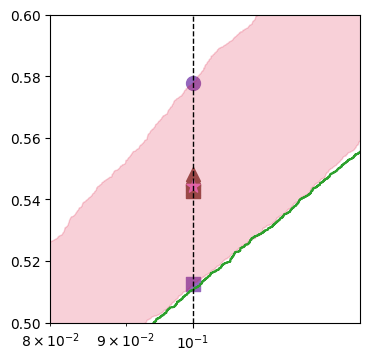

In [119]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sr')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

plt.figure(figsize=(4,4))
for i,m in enumerate(models):
    CCR = np.load(f'./_inference/oscr_result/gpu/{m}_CCR.npy')
    FPR = np.load(f'./_inference/oscr_result/gpu/{m}_FPR.npy')
    Threshold = np.load(f'./_inference/oscr_result/gpu/{m}_Threshold.npy')
    ccr_at_fpr = utilA.find_ccr_at_fpr(FPR,CCR,0.1)
    thr_at_fpr = utilA.find_thr_at_fpr(FPR,Threshold,0.1)
    print(f"{m}:")
    print(f"CCRofFPR@0.1 = {ccr_at_fpr:.4f}\t\t\tAccuracy = {CCR[0]:.4f}")
    print(f"THRofFPR@0.1 = {thr_at_fpr:.4f}")
    plt.scatter(0.1, ccr_at_fpr, label=m, marker=const.CUA_STYLES[m]['marker'], color=const.CUA_STYLES[m]['color'], s=100)

plt.fill_between(s_fpr_fill, s_ccr1_fill, s_ccr2_fill, interpolate=True, color='crimson', alpha=0.2)

m = 'var-CU'
CCR = np.load(f'./_inference/oscr_result/gpu/{m}_CCR.npy')
FPR = np.load(f'./_inference/oscr_result/gpu/{m}_FPR.npy')
plt.plot(FPR, CCR, label=m, color=const.VARIANTS_COLOR[m])

plt.xscale('log')
plt.xlim(0.08, 0.13)
plt.ylim(0.5, 0.6)
plt.axvline(0.1, color='black', ls='--', lw=1)
# plt.ylabel("balanced CCR")
# plt.xlabel("FPR")
# plt.legend()

['var-CUA-s', 'var-CUA-r', 'var-CUA-a', 'var-CUA-sr', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']


(0.2, 0.6)

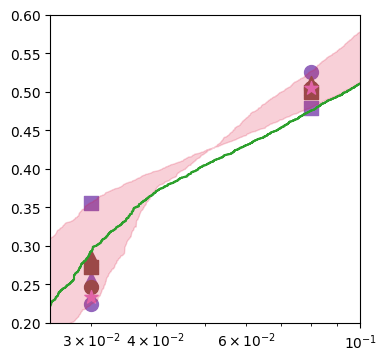

In [125]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sr')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

plt.figure(figsize=(4,4))
for i,m in enumerate(models):
    CCR = np.load(f'./_inference/oscr_result/gpu/{m}_CCR.npy')
    FPR = np.load(f'./_inference/oscr_result/gpu/{m}_FPR.npy')
    Threshold = np.load(f'./_inference/oscr_result/gpu/{m}_Threshold.npy')
    ccr_at_fpr = utilA.find_ccr_at_fpr(FPR,CCR,0.03)
    plt.scatter(0.03, ccr_at_fpr, label=m, marker=const.CUA_STYLES[m]['marker'], color=const.CUA_STYLES[m]['color'], s=100)
    ccr_at_fpr = utilA.find_ccr_at_fpr(FPR,CCR,0.08)
    plt.scatter(0.08, ccr_at_fpr, label=m, marker=const.CUA_STYLES[m]['marker'], color=const.CUA_STYLES[m]['color'], s=100)

plt.fill_between(s_fpr_fill, s_ccr1_fill, s_ccr2_fill, interpolate=True, color='crimson', alpha=0.2)

m = 'var-CU'
CCR = np.load(f'./_inference/oscr_result/gpu/{m}_CCR.npy')
FPR = np.load(f'./_inference/oscr_result/gpu/{m}_FPR.npy')
plt.plot(FPR, CCR, label=m, color=const.VARIANTS_COLOR[m])

plt.xscale('log')
plt.xlim(0.025, 0.1)
plt.ylim(0.2, 0.6)
# plt.axvline(0.1, color='black', ls='--', lw=1)
# plt.ylabel("balanced CCR")
# plt.xlabel("FPR")
# plt.legend()

['base', 'var-C', 'var-CU']
base:
CCRofFPR@0.1 = 0.0197			Accuracy = 0.2174
THRofFPR@0.1 = 0.9435
var-C:
CCRofFPR@0.1 = 0.0160			Accuracy = 0.2448
THRofFPR@0.1 = 0.9485
var-CU:
CCRofFPR@0.1 = 0.0546			Accuracy = 0.2268
THRofFPR@0.1 = 0.8050


Text(0.5, 0, 'FPR')

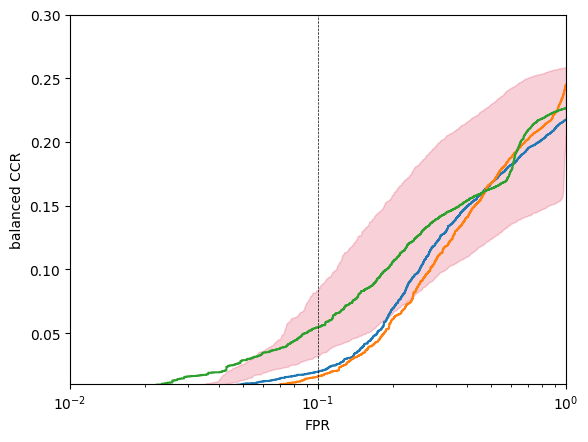

In [126]:
models = const.VARIANTS.copy()
# models.remove('base')
# models.remove('var-C')
models.remove('var-U')
# models.remove('var-CU')
models.remove('var-CUA-s')
models.remove('var-CUA-r')
models.remove('var-CUA-a')
models.remove('var-CUA-sr')
models.remove('var-CUA-sa')
models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

for m in models:
    CCR = np.load(f'./_inference/oscr_result/gpu/t_{m}_CCR.npy')
    FPR = np.load(f'./_inference/oscr_result/gpu/t_{m}_FPR.npy')
    Threshold = np.load(f'./_inference/oscr_result/gpu/t_{m}_Threshold.npy')
    ccr_at_fpr = utilA.find_ccr_at_fpr(FPR,CCR,0.1)
    thr_at_fpr = utilA.find_thr_at_fpr(FPR,Threshold,0.1)
    print(f"{m}:")
    print(f"CCRofFPR@0.1 = {ccr_at_fpr:.4f}\t\t\tAccuracy = {CCR[0]:.4f}")
    print(f"THRofFPR@0.1 = {thr_at_fpr:.4f}")   
    plt.plot(FPR, CCR, label=m, color=const.VARIANTS_COLOR[m])

t_fpr_fill, t_ccr1_fill, t_ccr2_fill = utilA.cua_oscr_range('var-CUA-r', 'var-CUA-a', is_target=True)
plt.fill_between(t_fpr_fill, t_ccr1_fill, t_ccr2_fill, interpolate=True, color='crimson', alpha=0.2)

plt.axvline(0.1, color='black', ls='--', lw=.5)
plt.xscale('log')
plt.xlim(0.01, 1)
plt.ylim(0.01, 0.3)
plt.ylabel("balanced CCR")
plt.xlabel("FPR")
# plt.legend()

['var-CUA-s', 'var-CUA-r', 'var-CUA-a', 'var-CUA-sr', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']
var-CUA-s:
CCRofFPR@0.1 = 0.0379			Accuracy = 0.2185
THRofFPR@0.1 = 0.8039
var-CUA-r:
CCRofFPR@0.1 = 0.0322			Accuracy = 0.2074
THRofFPR@0.1 = 0.8708
var-CUA-a:
CCRofFPR@0.1 = 0.0843			Accuracy = 0.2588
THRofFPR@0.1 = 0.7417
var-CUA-sr:
CCRofFPR@0.1 = 0.0475			Accuracy = 0.2241
THRofFPR@0.1 = 0.7717
var-CUA-ra:
CCRofFPR@0.1 = 0.0448			Accuracy = 0.2805
THRofFPR@0.1 = 0.8867
var-CUA-sa:
CCRofFPR@0.1 = 0.0479			Accuracy = 0.2635
THRofFPR@0.1 = 0.8037
var-CUA-sra:
CCRofFPR@0.1 = 0.0516			Accuracy = 0.2630
THRofFPR@0.1 = 0.8259


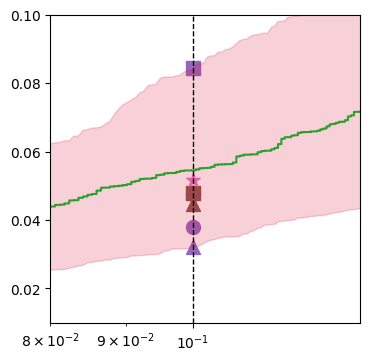

In [128]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sr')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

plt.figure(figsize=(4,4))
for i,m in enumerate(models):
    CCR = np.load(f'./_inference/oscr_result/gpu/t_{m}_CCR.npy')
    FPR = np.load(f'./_inference/oscr_result/gpu/t_{m}_FPR.npy')
    Threshold = np.load(f'./_inference/oscr_result/gpu/t_{m}_Threshold.npy')
    ccr_at_fpr = utilA.find_ccr_at_fpr(FPR,CCR,0.1)
    thr_at_fpr = utilA.find_thr_at_fpr(FPR,Threshold,0.1)
    print(f"{m}:")
    print(f"CCRofFPR@0.1 = {ccr_at_fpr:.4f}\t\t\tAccuracy = {CCR[0]:.4f}")
    print(f"THRofFPR@0.1 = {thr_at_fpr:.4f}")
    plt.scatter(0.1, ccr_at_fpr, label=m, marker=const.CUA_STYLES[m]['marker'], color=const.CUA_STYLES[m]['color'], s=100)

plt.fill_between(t_fpr_fill, t_ccr1_fill, t_ccr2_fill, interpolate=True, color='crimson', alpha=0.2)

m = 'var-CU'
CCR = np.load(f'./_inference/oscr_result/gpu/t_{m}_CCR.npy')
FPR = np.load(f'./_inference/oscr_result/gpu/t_{m}_FPR.npy')
plt.plot(FPR, CCR, label=m, color=const.VARIANTS_COLOR[m])

plt.xscale('log')
plt.xlim(0.08, 0.13)
plt.ylim(0.01, 0.1)
plt.axvline(0.1, color='black', ls='--', lw=1)
# plt.ylabel("balanced CCR")
# plt.xlabel("FPR")
# plt.legend()

['var-CUA-s', 'var-CUA-r', 'var-CUA-a', 'var-CUA-sr', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']


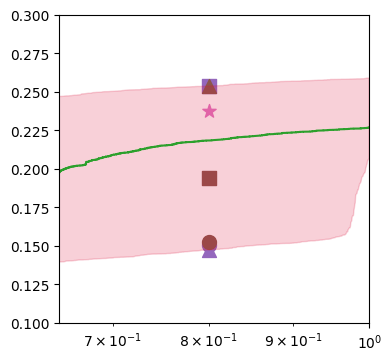

In [134]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sr')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

plt.figure(figsize=(4,4))
for i,m in enumerate(models):
    CCR = np.load(f'./_inference/oscr_result/gpu/t_{m}_CCR.npy')
    FPR = np.load(f'./_inference/oscr_result/gpu/t_{m}_FPR.npy')
    Threshold = np.load(f'./_inference/oscr_result/gpu/t_{m}_Threshold.npy')
    ccr_at_fpr = utilA.find_ccr_at_fpr(FPR,CCR,0.8)
    plt.scatter(0.8, ccr_at_fpr, label=m, marker=const.CUA_STYLES[m]['marker'], color=const.CUA_STYLES[m]['color'], s=100)

plt.fill_between(t_fpr_fill, t_ccr1_fill, t_ccr2_fill, interpolate=True, color='crimson', alpha=0.2)

m = 'var-CU'
CCR = np.load(f'./_inference/oscr_result/gpu/t_{m}_CCR.npy')
FPR = np.load(f'./_inference/oscr_result/gpu/t_{m}_FPR.npy')
plt.plot(FPR, CCR, label=m, color=const.VARIANTS_COLOR[m])

plt.xscale('log')
plt.xlim(0.65, 1)
plt.ylim(0.1, 0.3)
plt.axvline(0.1, color='black', ls='--', lw=1)
# plt.ylabel("balanced CCR")
# plt.xlabel("FPR")
# plt.legend()

# Open-set. Softmax Histogram

### Source

['base', 'var-C', 'var-CU', 'var-CUA-s']


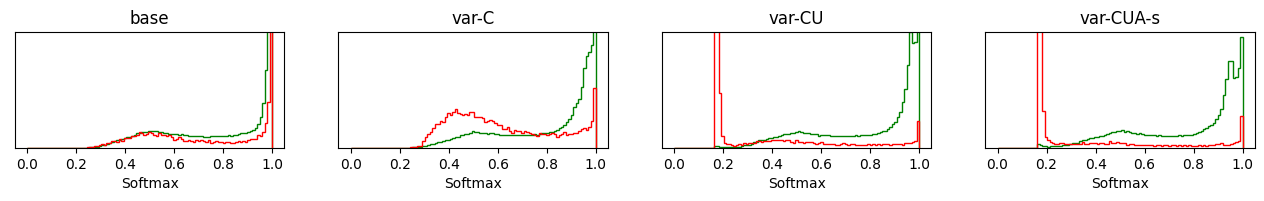

In [207]:
models = const.VARIANTS.copy()
models.remove('var-U')
models.remove('var-CUA-a')
models.remove('var-CUA-r')
models.remove('var-CUA-sa')
models.remove('var-CUA-sr')
models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

fig, axs = plt.subplots(ncols=len(models), nrows=1 ,figsize=(len(models)*4, 1*1.5),sharex=True)
bins = np.linspace(0,1,num=100)
for idx, m in enumerate(models):
    s_true, s_pred, s_logits, _ = source_load(m)
    s_softmax = utilA.cal_softmax_score(s_logits)

    kn = (s_true != 'unknown')
    unkn = ~kn
    s_kn_softmax = s_softmax[kn]
    s_unkn_softmax = s_softmax[unkn]

    axs[idx].hist(s_kn_softmax,color='green',histtype=u'step',density=True, bins=bins, stacked=False)
    # axs[idx].set_yticks([])
    # ax2 = axs[idx].twinx()
    axs[idx].hist(s_unkn_softmax,color='red',histtype=u'step',density=True, bins=bins, stacked=False)
    axs[idx].set_ylim(0,7.5)
    axs[idx].set_yticks([])
    axs[idx].set_xlabel('Softmax')
    axs[idx].set_title(m)
    # print(sum(kn)//10000, sum(unkn)//1000)

['var-CUA-r', 'var-CUA-a', 'var-CUA-sr', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']


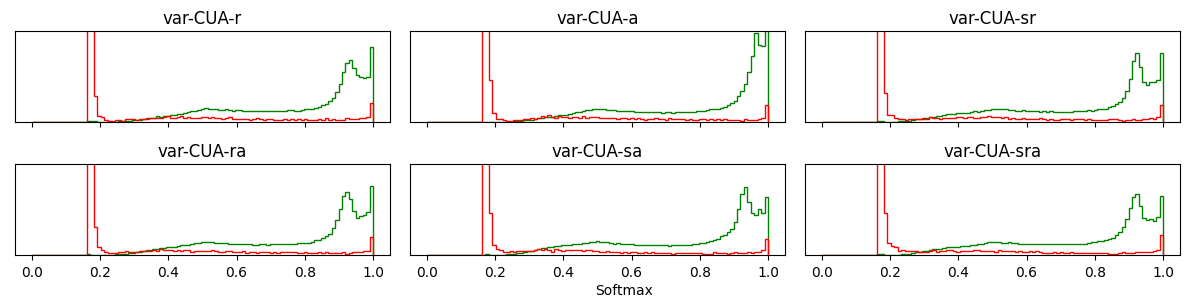

In [51]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
models.remove('var-CUA-s')
# models.remove('var-CUA-a')
# models.remove('var-CUA-r')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-sr')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

ncols = 3
nrows = len(models)//3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows ,figsize=(ncols*4, nrows*1.5),sharex=True)

bins = np.linspace(0,1,num=100)
for idx, m in enumerate(models):
    s_true, s_pred, s_logits, _ = source_load(m)
    s_softmax = utilA.cal_softmax_score(s_logits)

    kn = (s_true != 'unknown')
    unkn = ~kn
    s_kn_softmax = s_softmax[kn]
    s_unkn_softmax = s_softmax[unkn]

    axs[idx//ncols, idx%ncols].hist(s_kn_softmax,color='green',histtype=u'step',density=True, bins=bins, stacked=False)
    # axs[idx].set_yticks([])
    # ax2 = axs[idx].twinx()
    axs[idx//ncols, idx%ncols].hist(s_unkn_softmax,color='red',histtype=u'step',density=True, bins=bins, stacked=False)
    axs[idx//ncols, idx%ncols].set_ylim(0,7.5)
    axs[idx//ncols, idx%ncols].set_yticks([])
    # axs[idx//ncols, idx%ncols].set_xlabel('Softmax')
    axs[idx//ncols, idx%ncols].set_title(m)

fig.text(0.5,0,'Softmax', ha='left',)
fig.tight_layout()


['base', 'var-C', 'var-CU', 'var-CUA-s']
['bicycling']
['bicycling']
['bicycling']
['bicycling']


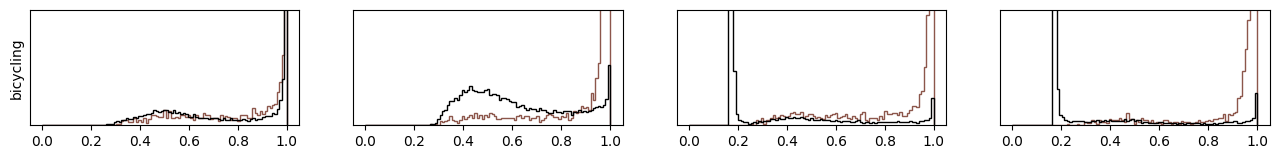

In [118]:
models = const.VARIANTS.copy()
models.remove('var-U')
models.remove('var-CUA-a')
models.remove('var-CUA-r')
models.remove('var-CUA-sa')
models.remove('var-CUA-sr')
models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

fig, axs = plt.subplots(ncols=len(models), nrows=1 ,figsize=(len(models)*4, 1*1.5),sharex=True)
bins = np.linspace(0,1,num=100)
for idx, m in enumerate(models):
    s_true, s_pred, s_logits, _ = source_load(m)
    s_softmax = utilA.cal_softmax_score(s_logits)

    label = 'bicycling' #'sit-stand','sleep','mixed','walking','vehicle','bicycling'
    kn = (s_true != 'unknown') 
    kn_label =  (s_true == label) 
    filter = kn & kn_label
    unkn = ~kn
    print(np.unique(s_true[filter]))

    s_kn_softmax = s_softmax[filter]
    s_unkn_softmax = s_softmax[unkn]

    axs[idx].hist(s_kn_softmax,color=const.LABEL_COLORS[label],histtype=u'step',density=True, bins=bins, stacked=False)
    # axs[idx].set_yticks([])
    # ax2 = axs[idx].twinx()
    axs[idx].hist(s_unkn_softmax,color='black',histtype=u'step',density=True, bins=bins, stacked=False)
    # axs[idx].set_title(m)
    axs[idx].set_ylim(0,7.5)
    axs[idx].set_yticks([])
    # axs[idx].set_xticklabels([])
    if idx == 0:
        axs[idx].set_ylabel(label)

### Target

['base', 'var-C', 'var-CU', 'var-CUA-a']


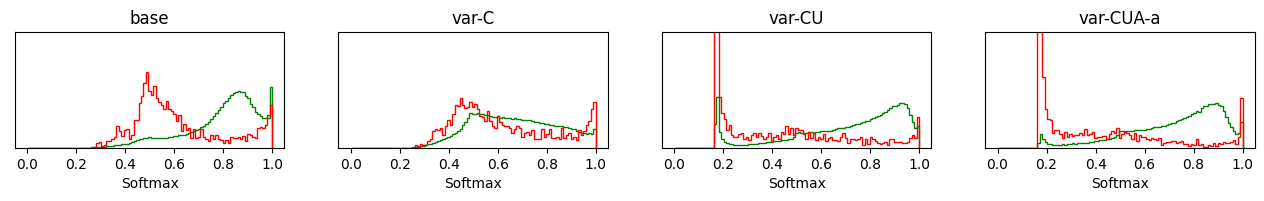

In [48]:
models = const.VARIANTS.copy()
models.remove('var-U')
models.remove('var-CUA-s')
models.remove('var-CUA-r')
models.remove('var-CUA-sa')
models.remove('var-CUA-sr')
models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

fig, axs = plt.subplots(ncols=len(models), nrows=1 ,figsize=(len(models)*4, 1*1.5),sharex=True)
bins = np.linspace(0,1,num=100)
for idx, m in enumerate(models):
    t_true, t_pred, t_logits, _ = target_load(m)
    t_softmax = utilA.cal_softmax_score(t_logits)

    kn = (t_true != 'unknown')
    unkn = ~kn
    t_kn_softmax = t_softmax[kn]
    t_unkn_softmax = t_softmax[unkn]


    axs[idx].hist(t_kn_softmax,color='green',histtype=u'step',density=True, bins=bins, stacked=False)
    # axs[idx].set_yticks([])
    # ax2 = axs[idx].twinx()
    axs[idx].hist(t_unkn_softmax,color='red',histtype=u'step',density=True, bins=bins, stacked=False)
    axs[idx].set_ylim(0,7.5)
    axs[idx].set_yticks([])
    axs[idx].set_xlabel('Softmax')
    axs[idx].set_title(m)

['var-CUA-s', 'var-CUA-r', 'var-CUA-sr', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']


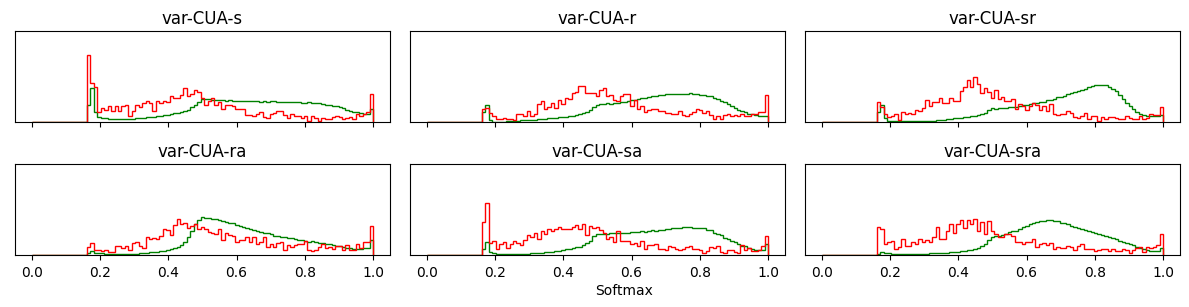

In [50]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
# models.remove('var-CUA-s')
models.remove('var-CUA-a')
# models.remove('var-CUA-r')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-sr')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

ncols = 3
nrows = len(models)//3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows ,figsize=(ncols*4, nrows*1.5),sharex=True)

bins = np.linspace(0,1,num=100)
for idx, m in enumerate(models):
    t_true, t_pred, t_logits, _ = target_load(m)
    t_softmax = utilA.cal_softmax_score(t_logits)

    kn = (t_true != 'unknown')
    unkn = ~kn
    t_kn_softmax = t_softmax[kn]
    t_unkn_softmax = t_softmax[unkn]

    axs[idx//ncols, idx%ncols].hist(t_kn_softmax,color='green',histtype=u'step',density=True, bins=bins, stacked=False)
    axs[idx//ncols, idx%ncols].hist(t_unkn_softmax,color='red',histtype=u'step',density=True, bins=bins, stacked=False)
    axs[idx//ncols, idx%ncols].set_ylim(0,7.5)
    axs[idx//ncols, idx%ncols].set_yticks([])
    axs[idx//ncols, idx%ncols].set_title(m)

fig.text(0.5,0,'Softmax', ha='left',)
fig.tight_layout()


['base', 'var-C', 'var-CU', 'var-CUA-a']
['sit-stand']
['sit-stand']
['sit-stand']
['sit-stand']


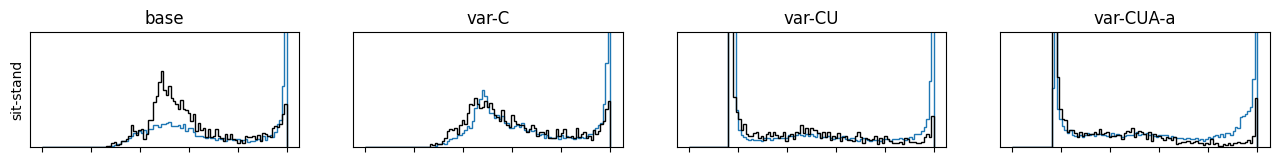

In [112]:
models = const.VARIANTS.copy()
models.remove('var-U')
models.remove('var-CUA-s')
models.remove('var-CUA-r')
models.remove('var-CUA-sa')
models.remove('var-CUA-sr')
models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

fig, axs = plt.subplots(ncols=len(models), nrows=1 ,figsize=(len(models)*4, 1*1.5),sharex=True)
bins = np.linspace(0,1,num=100)
for idx, m in enumerate(models):
    t_true, t_pred, t_logits, _ = target_load(m)
    t_softmax = utilA.cal_softmax_score(t_logits)

    label = 'sit-stand' #'sit-stand','sleep','mixed','walking','vehicle','bicycling'
    kn = (t_true != 'unknown') 
    kn_label =  (t_true == label) 
    filter = kn & kn_label
    unkn = ~kn
    print(np.unique(t_true[filter]))

    t_kn_softmax = t_softmax[filter]
    t_unkn_softmax = t_softmax[unkn]

    axs[idx].hist(t_kn_softmax,color=const.LABEL_COLORS[label],histtype=u'step',density=True, bins=bins, stacked=False)
    # axs[idx].set_yticks([])
    # ax2 = axs[idx].twinx()
    axs[idx].hist(t_unkn_softmax,color='black',histtype=u'step',density=True, bins=bins, stacked=False)
    axs[idx].set_title(m)
    axs[idx].set_ylim(0,7.5)
    axs[idx].set_yticks([])
    axs[idx].set_xticklabels([])
    if idx == 0:
        axs[idx].set_ylabel(label)

# Closed-set. balanced Accuracy

In [74]:
models = const.VARIANTS.copy()
models.remove('var-U')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sr')
# models.remove('var-CUA-sra')
print(models)

for model in models:

    true, pred, _, _ = source_load(model)
    
    # Include only known samples
    kn = (true != 'unknown')
    true = true[kn]
    pred = pred[kn]

    f1, k, acc = utilA.multi_class_eval(true, pred)
    print(f"{model} source+unknown ")
    print(f"Only consider known samples : {len(kn)} -> {sum(kn)}")
    print(f"Macro F1-score: {f1:.5f}\nCohen's kappa: {k:.4f}\nBalanced Accuracry: {acc:.4f}")
    print()

['base', 'var-C', 'var-CU', 'var-CUA-s', 'var-CUA-r', 'var-CUA-a', 'var-CUA-sr', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']
base source+unknown 
Only consider known samples : 216381 -> 200756
Macro F1-score: 0.62158
Cohen's kappa: 0.6082
Balanced Accuracry: 0.6638

var-C source+unknown 
Only consider known samples : 216381 -> 200756
Macro F1-score: 0.60578
Cohen's kappa: 0.5758
Balanced Accuracry: 0.6506

var-CU source+unknown 
Only consider known samples : 216381 -> 200756
Macro F1-score: 0.58438
Cohen's kappa: 0.5720
Balanced Accuracry: 0.6396

var-CUA-s source+unknown 
Only consider known samples : 216381 -> 200756
Macro F1-score: 0.60334
Cohen's kappa: 0.5712
Balanced Accuracry: 0.6710

var-CUA-r source+unknown 
Only consider known samples : 216381 -> 200756
Macro F1-score: 0.61695
Cohen's kappa: 0.5824
Balanced Accuracry: 0.6754

var-CUA-a source+unknown 
Only consider known samples : 216381 -> 200756
Macro F1-score: 0.60584
Cohen's kappa: 0.5817
Balanced Accuracry: 0.6383

var-CU

In [50]:
models = const.VARIANTS.copy()
models.remove('var-U')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sr')
# models.remove('var-CUA-sra')
print(models)

t_dataset = const.DS_LABEL.copy()
t_dataset.remove('source')
t_dataset.remove('source+unknown')
print(t_dataset)

f1_byModel = []
k_byModel = []
acc_byModel = []
for model in models:
    print(f"{model}")
    true_all = []
    pred_all = []
    for data in t_dataset:
        true = np.load(load_data[model][data]['true'])
        pred = np.load(load_data[model][data]['pred'])

        # Include only known samples
        kn = (true != 'unknown')
        true = true[kn]
        pred = pred[kn]

        # f1, k, acc = utilA.multi_class_eval(true, pred)
        print(f"Only consider known samples : {len(kn)} -> {sum(kn)}")
        # f1_byData.append(f1)
        # k_byData.append(k)
        # acc_byData.append(acc)
        # print(type(true), type(pred), len(true_all))
        true_all += list(true)
        pred_all += list(pred)
        
    true_all = np.array(true_all)
    pred_all = np.array(pred_all)
    f1, k, acc = utilA.multi_class_eval(true_all, pred_all)
    print("Total target domain samples: ",len(true_all))
    print(f"Macro F1-score: {f1:.5f}\nCohen's kappa: {k:.4f}\nBalanced Accuracry: {acc:.4f}")
    print()
    print()

['base', 'var-C', 'var-CU', 'var-CUA-s', 'var-CUA-r', 'var-CUA-a', 'var-CUA-sr', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']
['target-1.1', 'target-1.2', 'target-1.3', 'target-2.1', 'target-2.2', 'target-2.3', 'target-3.1', 'target-3.2']
base
Only consider known samples : 1594 -> 1297
Only consider known samples : 6139 -> 6008
Only consider known samples : 3644 -> 2409
Only consider known samples : 3882 -> 3882
Only consider known samples : 9642 -> 9642
Only consider known samples : 1327 -> 1327
Only consider known samples : 3488 -> 3488
Only consider known samples : 365776 -> 365776
Total target domain samples:  393829
Macro F1-score: 0.09895
Cohen's kappa: -0.0290
Balanced Accuracry: 0.2174


var-C
Only consider known samples : 1594 -> 1297
Only consider known samples : 6139 -> 6008
Only consider known samples : 3644 -> 2409
Only consider known samples : 3882 -> 3882
Only consider known samples : 9642 -> 9642
Only consider known samples : 1327 -> 1327
Only consider known samples : 348

# Closed-set. Confusion Matrix

### Source

['base', 'var-C', 'var-CU', 'var-CUA-sr']


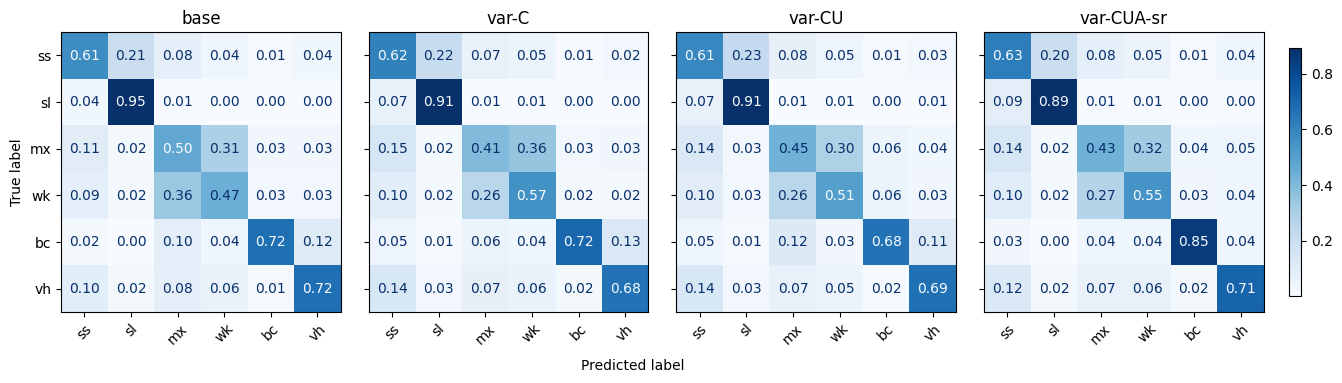

In [193]:
models = const.VARIANTS.copy()
models.remove('var-U')
models.remove('var-CUA-s')
models.remove('var-CUA-r')
models.remove('var-CUA-a')
models.remove('var-CUA-sa')
# models.remove('var-CUA-sr')
models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

fig, axs = plt.subplots(ncols=len(models), nrows=1 ,figsize=(len(models)*4, 1*4))

for idx, m in enumerate(models):
    s_true, s_pred, _, _ = source_load(m)

    kn = (s_true != 'unknown')
    unkn = ~kn
    s_true = s_true[kn]
    s_pred = s_pred[kn]

    disp = utilA.get_confusionMatrix(s_true, s_pred)
    
    disp.plot(ax=axs[idx], cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=45)
    disp.ax_.set_title(m)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if idx!=0:
        disp.ax_.set_ylabel('')
        disp.ax_.set_yticklabels('')

fig.text(0.45,0,'Predicted label', ha='left',)
plt.subplots_adjust(wspace=0.10, hspace=0.1)

fig.colorbar(disp.im_, ax=axs, fraction=0.01, pad=0.02)
plt.show()

['var-CUA-s', 'var-CUA-r', 'var-CUA-a', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']


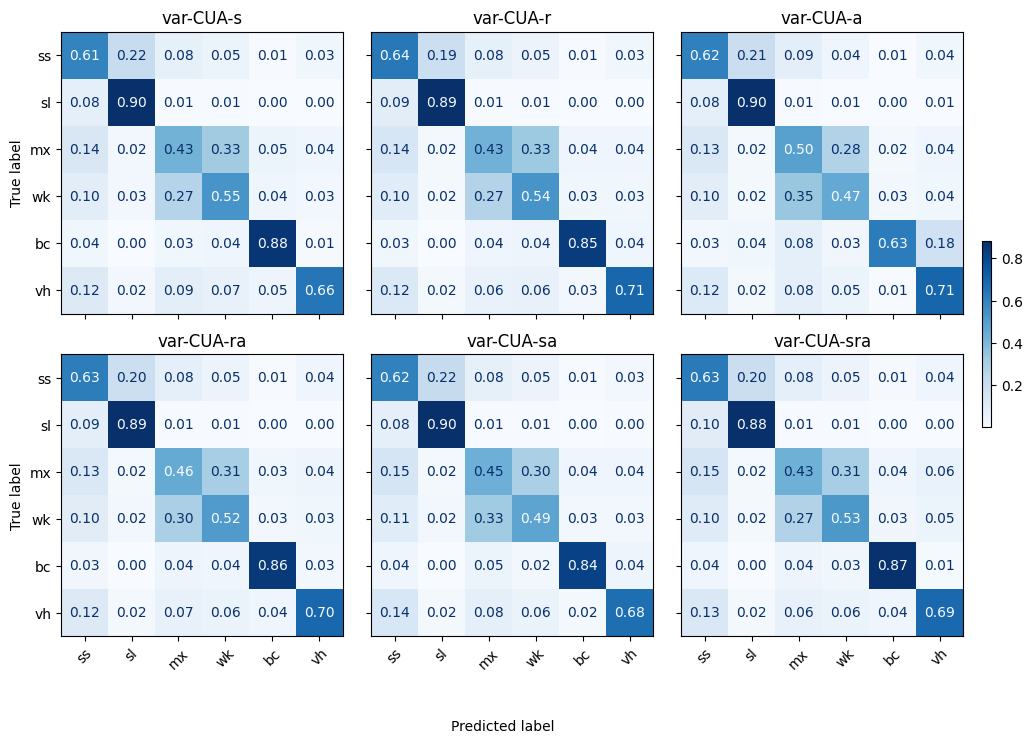

In [34]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sa')
models.remove('var-CUA-sr')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

ncols = 3
nrows = len(models)//3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows ,figsize=(ncols*4, nrows*4))

for idx, m in enumerate(models):
    s_true, s_pred, _, _ = source_load(m)

    kn = (s_true != 'unknown')
    unkn = ~kn
    s_true = s_true[kn]
    s_pred = s_pred[kn]

    disp = utilA.get_confusionMatrix(s_true, s_pred)
    
    disp.plot(ax=axs[idx//ncols, idx%ncols], cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=45)
    disp.ax_.set_title(m)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if (idx%ncols)!=0:
        disp.ax_.set_ylabel('')
        disp.ax_.set_yticklabels('')
    if (idx//ncols)==0:
        disp.ax_.set_xlabel('')
        disp.ax_.set_xticklabels('')

fig.text(0.45,0,'Predicted label', ha='left',)
plt.subplots_adjust(wspace=0.10, hspace=0.1)

fig.colorbar(disp.im_, ax=axs, fraction=0.01, pad=0.02)
plt.show()

### Target

['base', 'var-C', 'var-CU', 'var-CUA-ra']


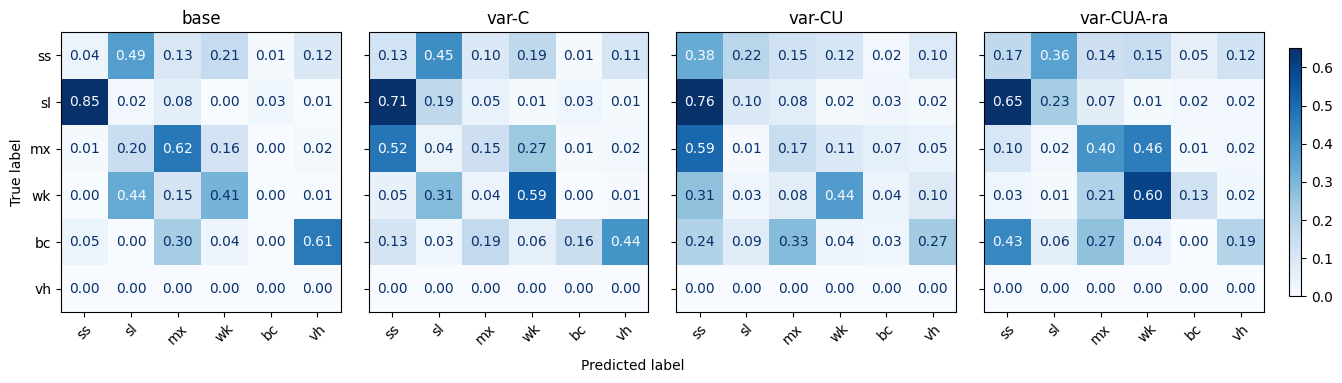

In [194]:
models = const.VARIANTS.copy()
models.remove('var-U')
models.remove('var-CUA-s')
models.remove('var-CUA-r')
models.remove('var-CUA-a')
models.remove('var-CUA-sa')
models.remove('var-CUA-sr')
# models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

fig, axs = plt.subplots(ncols=len(models), nrows=1 ,figsize=(len(models)*4, 1*4))

for idx, m in enumerate(models):
    t_true, t_pred, _, _ = target_load(m)

    kn = (t_true != 'unknown')
    unkn = ~kn
    t_true = t_true[kn]
    t_pred = t_pred[kn]

    disp = utilA.get_confusionMatrix(t_true, t_pred)
    
    disp.plot(ax=axs[idx], cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=45)
    disp.ax_.set_title(m)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if idx!=0:
        disp.ax_.set_ylabel('')
        disp.ax_.set_yticklabels('')

fig.text(0.45,0,'Predicted label', ha='left',)
plt.subplots_adjust(wspace=0.10, hspace=0.1)

fig.colorbar(disp.im_, ax=axs, fraction=0.01, pad=0.02)
plt.show()

['var-CUA-s', 'var-CUA-r', 'var-CUA-a', 'var-CUA-sr', 'var-CUA-sa', 'var-CUA-sra']


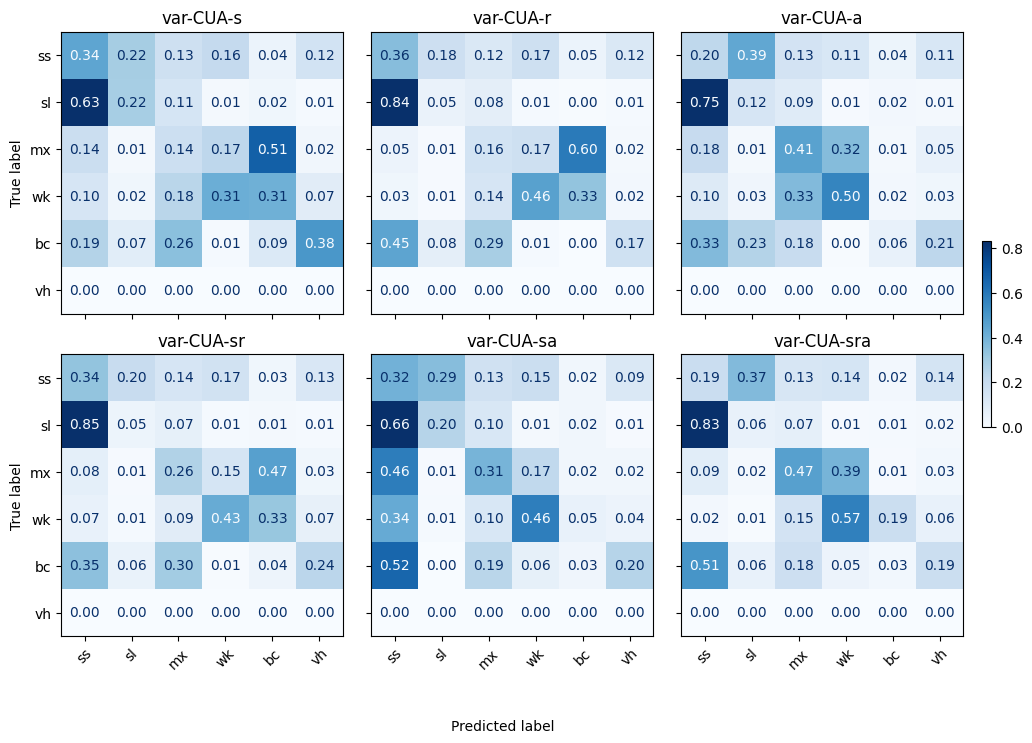

In [37]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-sr')
models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

ncols = 3
nrows = len(models)//3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows ,figsize=(ncols*4, nrows*4))

for idx, m in enumerate(models):
    t_true, t_pred, _, _ = target_load(m)

    kn = (t_true != 'unknown')
    unkn = ~kn
    t_true = t_true[kn]
    t_pred = t_pred[kn]

    disp = utilA.get_confusionMatrix(t_true, t_pred)
    
    disp.plot(ax=axs[idx//ncols, idx%ncols], cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=45)
    disp.ax_.set_title(m)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if (idx%ncols)!=0:
        disp.ax_.set_ylabel('')
        disp.ax_.set_yticklabels('')
    if (idx//ncols)==0:
        disp.ax_.set_xlabel('')
        disp.ax_.set_xticklabels('')

fig.text(0.45,0,'Predicted label', ha='left',)
plt.subplots_adjust(wspace=0.10, hspace=0.1)

fig.colorbar(disp.im_, ax=axs, fraction=0.01, pad=0.02)
plt.show()

# Semantic Analysis. Visualizing Deep Feature Space

### Generate 2D deep features

In [52]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
models.remove('var-CUA-s')
# models.remove('var-CUA-r')
# models.remove('var-CUA-a')
# models.remove('var-CUA-sa')
models.remove('var-CUA-sr')
# models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

for idx, m in enumerate(models):
    s_true, s_pred, _, s_feats = source_load(m, feats_out=True)

    # Deep Feature space visualziation
    s_feats, s_true = utilA.sampling_by_label(s_feats, s_true, samples=1000, label_balance=True, is_verbose=False)
    s_feats_red = utilA.reduceme(s_feats, PCA=False, UMAP=True)
    print(s_feats.shape, s_feats_red.shape, s_true.shape)

    save_path = os.path.join('./umap/', m)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.save(os.path.join(save_path, 's_feats_red.npy'), s_feats_red)
    np.save(os.path.join(save_path, 's_true_label.npy'), s_true)

['var-CUA-r', 'var-CUA-a', 'var-CUA-ra', 'var-CUA-sa', 'var-CUA-sra']
(994, 1046) (994, 2) (994,)
(994, 1046) (994, 2) (994,)
(994, 1046) (994, 2) (994,)
(994, 1046) (994, 2) (994,)
(994, 1046) (994, 2) (994,)


In [53]:
models = const.VARIANTS.copy()
models.remove('base')
models.remove('var-C')
models.remove('var-U')
models.remove('var-CU')
# models.remove('var-CUA-s')
# models.remove('var-CUA-r')
models.remove('var-CUA-a')
# models.remove('var-CUA-sa')
# models.remove('var-CUA-sr')
models.remove('var-CUA-ra')
# models.remove('var-CUA-sra')
print(models)

for idx, m in enumerate(models):
    t_true, t_pred, _, t_feats = target_load(m, feats_out=True)

    # Deep Feature space visualziation
    print(t_feats.shape)
    t_feats, t_true = utilA.sampling_by_label(t_feats, t_true, samples=1000, label_balance=True, is_verbose=False)
    t_feats_red = utilA.reduceme(t_feats, PCA=False, UMAP=True)
    print(t_feats.shape, t_feats_red.shape, t_true.shape)

    save_path = os.path.join('./umap/', m)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.save(os.path.join(save_path, 't_feats_red.npy'), t_feats_red)
    np.save(os.path.join(save_path, 't_true_label.npy'), t_true)

['var-CUA-s', 'var-CUA-r', 'var-CUA-sr', 'var-CUA-sa', 'var-CUA-sra']
(395492, 1046)
(996, 1046) (996, 2) (996,)
(395492, 1046)
(996, 1046) (996, 2) (996,)
(395492, 1046)
(996, 1046) (996, 2) (996,)
(395492, 1046)
(996, 1046) (996, 2) (996,)
(395492, 1046)
(996, 1046) (996, 2) (996,)


### Plotting (all together)

['base', 'var-C', 'var-CU', 'var-CUA-s', 'var-CUA-sr']


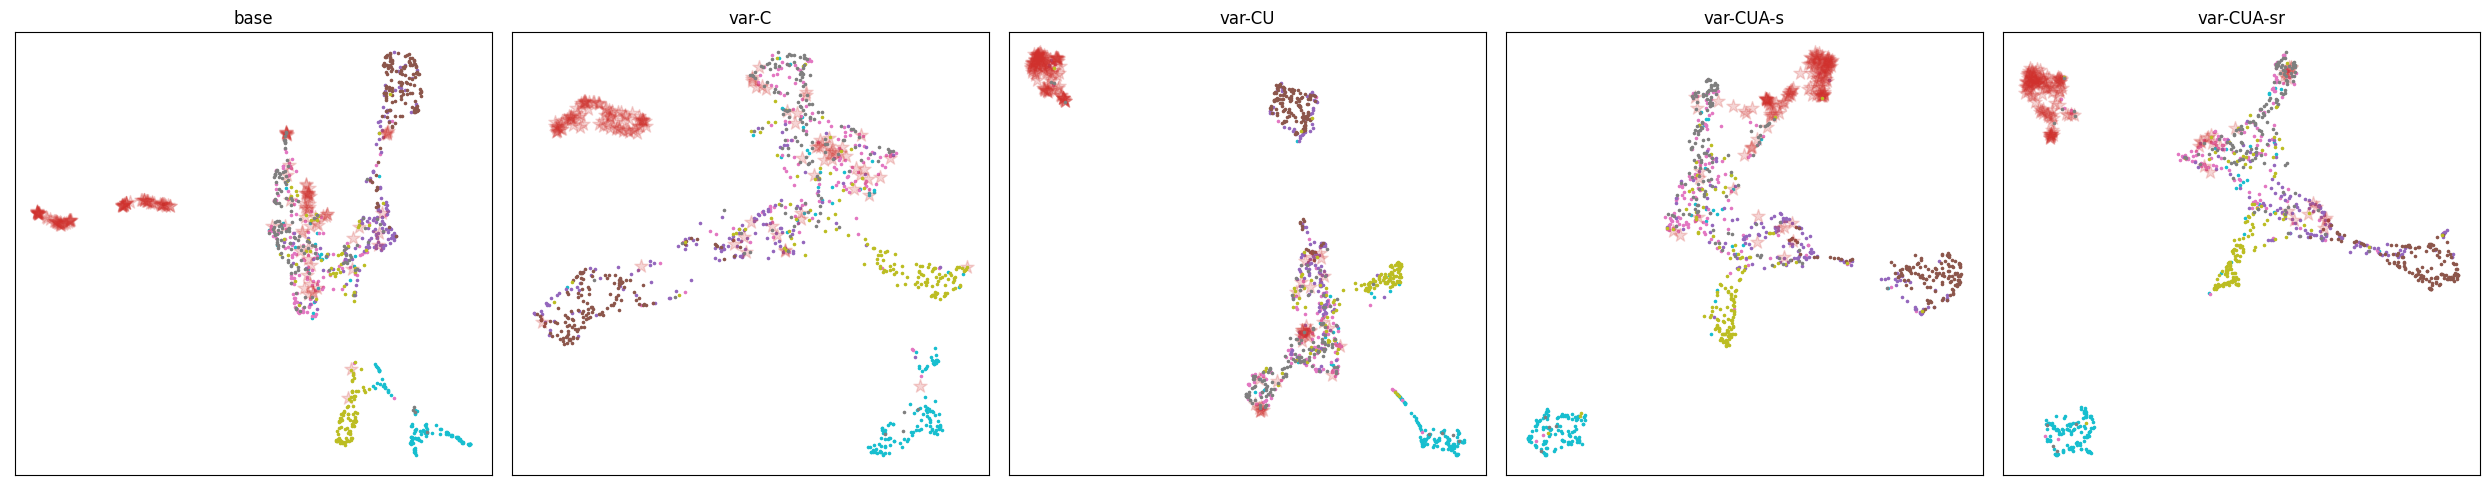

In [152]:
models = const.VARIANTS.copy()
models.remove('var-U')
# models.remove('var-CUA-s')
models.remove('var-CUA-r')
models.remove('var-CUA-a')
models.remove('var-CUA-sa')
# models.remove('var-CUA-sr')
models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

fig, axs = plt.subplots(ncols=len(models), nrows=1 ,figsize=(len(models)*5, 1*5))

for idx, m in enumerate(models):
    umap_data_path = os.path.join(root, 'umap', m)
    t_true = np.load(os.path.join(umap_data_path, 's_true_label.npy'))
    t_feats_red = np.load(os.path.join(umap_data_path, 's_feats_red.npy'))

    for lb in np.unique(t_true):
        # if lb != 'unknown':
        # print(lb)
        color = const.LABEL_COLORS[lb]
        x1 = t_feats_red[lb == t_true][:,0]
        x2 = t_feats_red[lb == t_true][:,1]
        if lb != 'unknown':
            axs[idx].scatter(x1, x2, c=np.array([color]), s=10, marker='.')
        else:
            axs[idx].scatter(x1, x2, c=np.array([color]), s=100, marker='*', alpha=0.2)

    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].set_xticklabels([])
    axs[idx].set_yticklabels([])
    axs[idx].set_title(m)

fig.tight_layout()

['base', 'var-C', 'var-CU', 'var-CUA-a', 'var-CUA-ra']


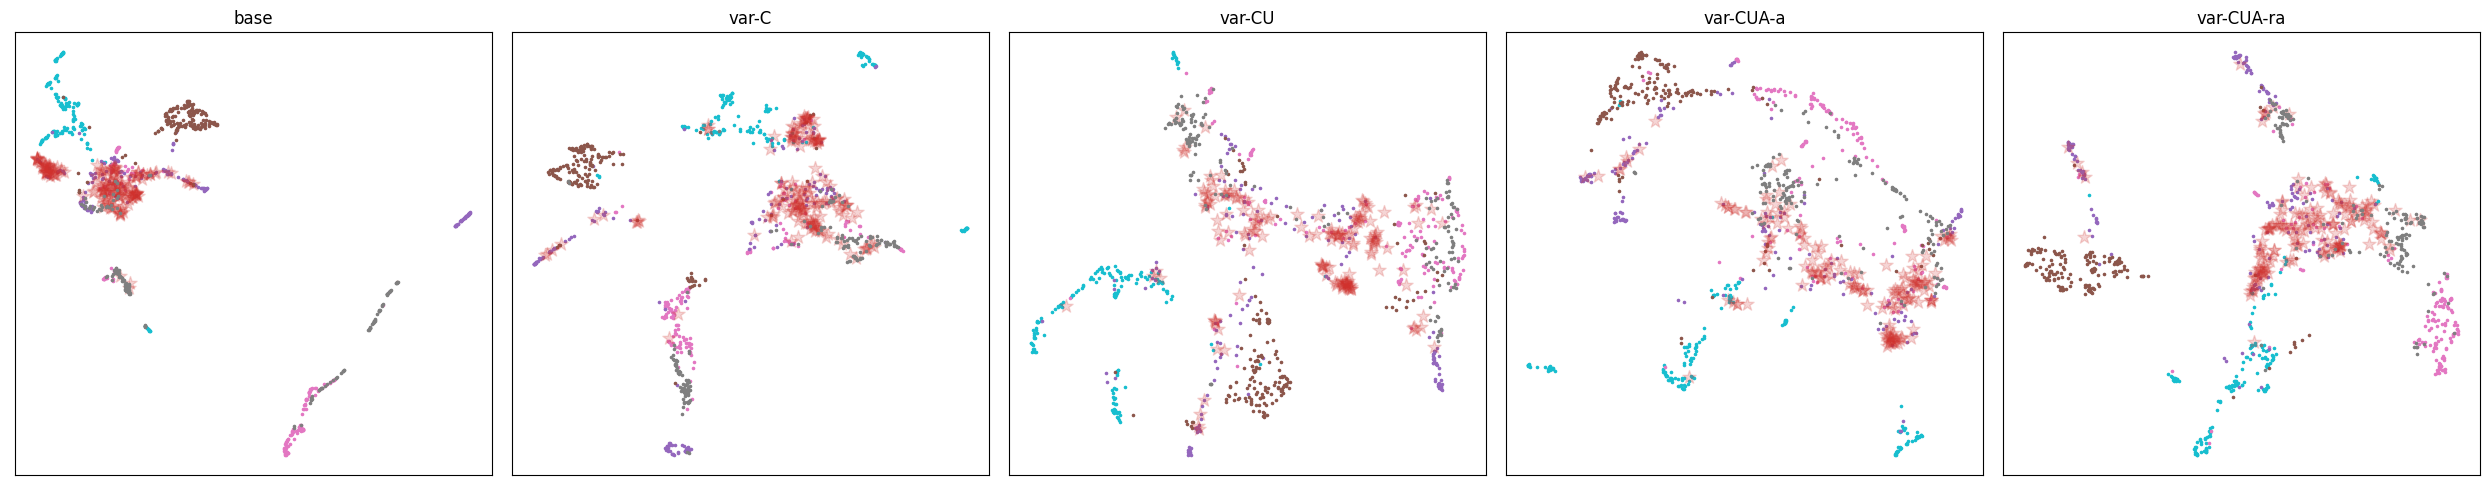

In [148]:
models = const.VARIANTS.copy()
models.remove('var-U')
models.remove('var-CUA-s')
models.remove('var-CUA-r')
# models.remove('var-CUA-a')
models.remove('var-CUA-sa')
models.remove('var-CUA-sr')
# models.remove('var-CUA-ra')
models.remove('var-CUA-sra')
print(models)

fig, axs = plt.subplots(ncols=len(models), nrows=1 ,figsize=(len(models)*5, 1*5))

for idx, m in enumerate(models):
    umap_data_path = os.path.join(root, 'umap', m)
    t_true = np.load(os.path.join(umap_data_path, 't_true_label.npy'))
    t_feats_red = np.load(os.path.join(umap_data_path, 't_feats_red.npy'))

    for lb in np.unique(t_true):
        # if lb != 'unknown':
        # print(lb)
        color = const.LABEL_COLORS[lb]
        x1 = t_feats_red[lb == t_true][:,0]
        x2 = t_feats_red[lb == t_true][:,1]
        if lb != 'unknown':
            axs[idx].scatter(x1, x2, c=np.array([color]), s=10, marker='.')
        else:
            axs[idx].scatter(x1, x2, c=np.array([color]), s=100, marker='*', alpha=0.2)

    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].set_xticklabels([])
    axs[idx].set_yticklabels([])
    axs[idx].set_title(m)

fig.tight_layout()

### Plotting (one by one)

var-CUA-sra


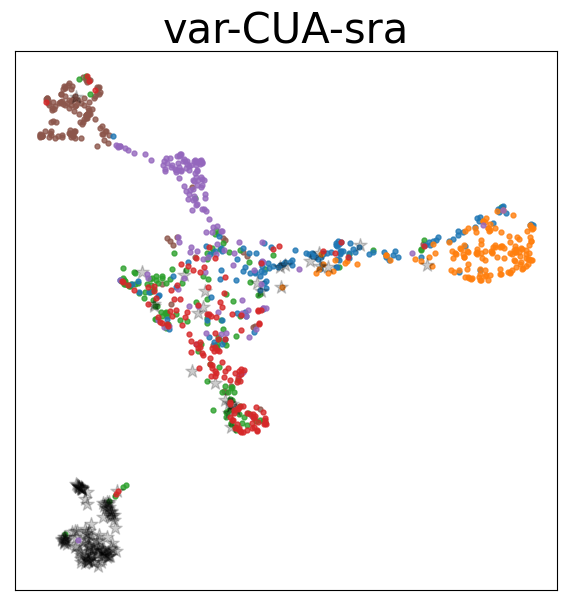

In [59]:
# models = ['base', 'var-C', 'var-CU', 'var-CUA-s', 'var-CUA-sr']
models = ['var-CUA-r', 'var-CUA-a', 'var-CUA-sa', 'var-CUA-ra', 'var-CUA-sra']
m = models[4]
print(m)

umap_data_path = os.path.join(root, 'umap', m)
t_true = np.load(os.path.join(umap_data_path, 's_true_label.npy'))
t_feats_red = np.load(os.path.join(umap_data_path, 's_feats_red.npy'))

plt.figure(figsize=(7,7))
for lb in np.unique(t_true):
    # if lb != 'unknown':
    # print(lb)
    color = const.LABEL_COLORS[lb]
    x1 = t_feats_red[lb == t_true][:,0]
    x2 = t_feats_red[lb == t_true][:,1]
    if lb != 'unknown':
        plt.scatter(x1, x2, c=np.array([color]), s=50, marker='.', alpha=0.8)
    else:
        plt.scatter(x1, x2, c=np.array([color]), s=100, marker='*', alpha=0.2)

plt.xticks([])
plt.yticks([])
plt.xticks([])
plt.yticks([])
plt.title(m,fontsize=30)

fig.tight_layout()

var-CUA-sra


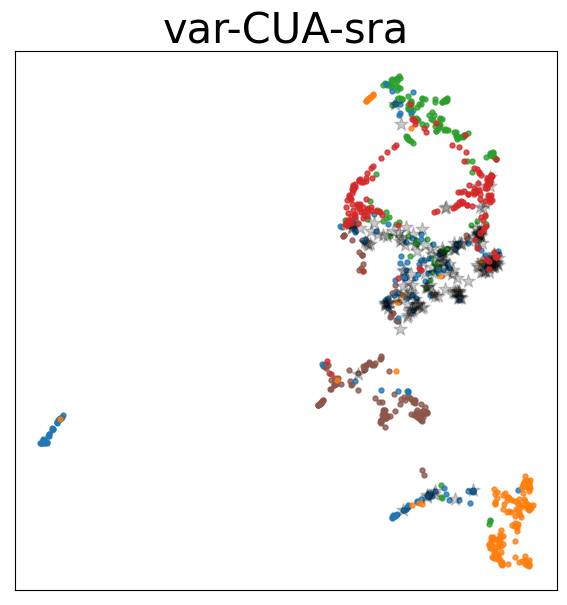

In [64]:
# models = ['base', 'var-C', 'var-CU', 'var-CUA-a', 'var-CUA-ra']
models = ['var-CUA-s', 'var-CUA-r', 'var-CUA-sr', 'var-CUA-sa', 'var-CUA-sra']

m = models[4]
print(m)

umap_data_path = os.path.join(root, 'umap', m)
t_true = np.load(os.path.join(umap_data_path, 't_true_label.npy'))
t_feats_red = np.load(os.path.join(umap_data_path, 't_feats_red.npy'))

plt.figure(figsize=(7,7))
for lb in np.unique(t_true):
    # if lb != 'unknown':
    # print(lb)
    color = const.LABEL_COLORS[lb]
    x1 = t_feats_red[lb == t_true][:,0]
    x2 = t_feats_red[lb == t_true][:,1]
    if lb != 'unknown':
        plt.scatter(x1, x2, c=np.array([color]), s=50, marker='.', alpha=0.8)
    else:
        plt.scatter(x1, x2, c=np.array([color]), s=100, marker='*', alpha=0.2)

plt.xticks([])
plt.yticks([])
plt.xticks([])
plt.yticks([])
plt.title(m)
plt.title(m,fontsize=30)

fig.tight_layout()

# Legend

In [85]:
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS

target_c = colors['tab:blue']

NEW_DS_LABEL = list(set(const.DS_LABEL) - set(['source+unknown']))
NEW_DS_LABEL.sort()
print(NEW_DS_LABEL)


ds_map_label_name = dict(zip(const.DS_LABEL, const.DS_NAME))


['source', 'target-1.1', 'target-1.2', 'target-1.3', 'target-2.1', 'target-2.2', 'target-2.3', 'target-3.1', 'target-3.2']


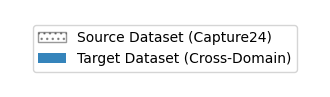

In [86]:
legend_elements = [Patch(fill=False, alpha=0.4, hatch='...',
                         label='Source Dataset (Capture24)'),
                   Patch(facecolor=target_c, alpha=0.9,
                         label='Target Dataset (Cross-Domain)')]

# # Create the figure
fig, ax = plt.subplots(figsize=(4,1))
ax.legend(handles=legend_elements, loc='center')
fig.patch.set_visible(False)
ax.axis('off')
plt.show()

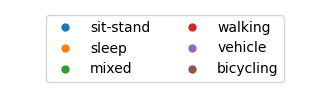

In [219]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = []
for k in const.LABEL_COLORS.keys():
    if k != 'unknown':
        label = k
        color = const.LABEL_COLORS[k]
        # print(label, color)
        element = Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=7)
        legend_elements.append(element)
        
# # Create the figure
fig, ax = plt.subplots(figsize=(4,1))
ax.legend(handles=legend_elements, loc='center', ncol=2)
fig.patch.set_visible(False)
ax.axis('off')
plt.show()

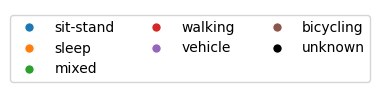

In [221]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = []
for k in const.LABEL_COLORS.keys():
    label = k
    color = const.LABEL_COLORS[k]
    # print(label, color)
    element = Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=7)
    legend_elements.append(element)
        
# # Create the figure
fig, ax = plt.subplots(figsize=(4,1))
ax.legend(handles=legend_elements, loc='center', ncol=3)
fig.patch.set_visible(False)
ax.axis('off')
plt.show()

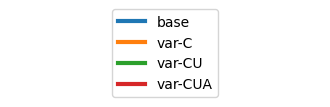

In [195]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = []
for k in const.VARIANTS_COLOR.keys():
    label = k
    color = const.VARIANTS_COLOR[k]
    # print(label, color)
    element = Line2D([0], [0], color=color, label=label, linewidth=3)
    legend_elements.append(element)
        
# # Create the figure
fig, ax = plt.subplots(figsize=(4,1))
ax.legend(handles=legend_elements, loc='center')
fig.patch.set_visible(False)
ax.axis('off')
plt.show()

In [200]:
a = 'var-CUA-sar'
b = a.split('var-CUA-')
print(b)

['', 'sar']


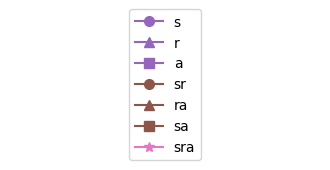

In [202]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = []
for k in const.CUA_STYLES.keys():
    label = k.split('var-CUA-')[1]
    marker = const.CUA_STYLES[k]['marker']
    color = const.CUA_STYLES[k]['color']
    # print(label, color)
    element = Line2D([0], [0], marker=marker, color=color, label=label, markerfacecolor=color, markersize=7)
    legend_elements.append(element)
        
# # Create the figure
fig, ax = plt.subplots(figsize=(4,1))
ax.legend(handles=legend_elements, loc='center')
fig.patch.set_visible(False)
ax.axis('off')
plt.show()

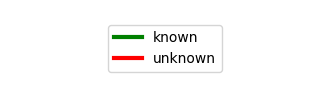

In [89]:

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='green', label='known', linewidth=3),
                   Line2D([0], [0], color='red', label='unknown', linewidth=3)]
        
# # Create the figure
fig, ax = plt.subplots(figsize=(4,1))
ax.legend(handles=legend_elements, loc='center')
fig.patch.set_visible(False)
ax.axis('off')
plt.show()